### Get data

#### Import the data as a pandas dataframe

In [13]:
import numpy as np
import pandas as pd

In [14]:
train = pd.read_csv("../data/labeledTrainData.tsv", header=0, delimiter="\t")

In [15]:
# Limit the data to 1000 rows for quick exploration
train = train.head(1000)

### Explore data

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
train.head()

,id,sentiment,review,processed_review
0,5814_8,1,With all this stuff going down at the moment w...,"[stuff, going, moment, mj, started, listening,..."
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...","[classic, war, worlds, timothy, hines, enterta..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,"[film, starts, manager, nicholas, bell, giving..."
3,3630_4,0,It must be assumed that those who praised this...,"[must, assumed, praised, film, greatest, filme..."
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,"[superbly, trashy, wondrously, unpretentious, ..."


In [29]:
train['length'] = train['review'].apply(len)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f125d06d8d0>,
      dtype=object)

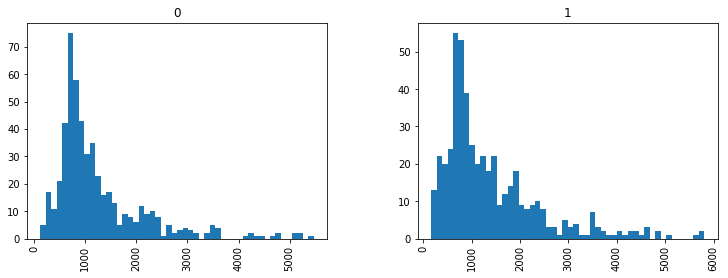

In [30]:
train.hist(column='length', by='sentiment', bins=50,figsize=(12,4))

### Process and transform data

In [17]:
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re

In [18]:
def process_text(raw_text):
    '''
    This function processes raw text by removing HTML markup,
    removing punctuation, numbers, and stopwords, and converts to a
    list of words.
    '''
    # Remove HTML
    processed_text = BeautifulSoup(raw_text).get_text()
    
    # Remove punctuation and numbers
    processed_text = re.sub("[^a-zA-Z]", " ", processed_text)
    
    # Convert to list of lower case words
    processed_text = processed_text.lower().split()
    
    # Remove stop words
    processed_text = [word for word in processed_text if word not in stopwords.words('english')]

    return processed_text

In [19]:
# Store the processed review text in a new column of the dataframe
train['processed_review'] = train['review'].apply(process_text)

Vectorize the texts using the tfidf-vectorizer

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
tfidf = TfidfVectorizer(analyzer=process_text).fit_transform(train['review'])

### Fit and evaluate models

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tfidf , train['sentiment'])

In [24]:
# Naive Bayes

from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(X_train, y_train)
predictions = model.predict(tfidf)
from sklearn.metrics import classification_report
print (classification_report(train['sentiment'], predictions))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       518
           1       0.97      0.90      0.93       482

   micro avg       0.94      0.94      0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



In [25]:
# Random forest classifier

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 100).fit(X_train, y_train)
predictions = model.predict(tfidf)
from sklearn.metrics import classification_report
print (classification_report(train['sentiment'], predictions))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       518
           1       0.94      0.94      0.94       482

   micro avg       0.94      0.94      0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



In [26]:
# Logistic regression classifier

from sklearn.linear_model import LogisticRegression
model = LogisticRegression().fit(X_train, y_train)
predictions = model.predict(tfidf)
from sklearn.metrics import classification_report
print (classification_report(train['sentiment'], predictions))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       518
           1       0.95      0.94      0.95       482

   micro avg       0.95      0.95      0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



/home/lily/nm587/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Using word2vec

Instead of tf-idf vectorization, we can try to vectorize our reviews using 
Google's pre-trained word2vec embedding downloaded from: https://code.google.com/archive/p/word2vec/

In [50]:
import gensim
# from gensim.models import Word2Vec
#Load Google's pre-trained Word2Vec 
model = gensim.models.KeyedVectors.load_word2vec_format('../../data/GoogleNews-vectors-negative300.bin', binary=True) 

#### Method 1: average the word vectors 

In [51]:
# This function converts a document into a vector by averaging 
# the individual word vectors

def doc2vec(doc):
    vec = np.zeros((300,),dtype="float32")
    nwords = 0
    for word in doc:
        if word in model.index2word:
            nwords += 1
            vec = np.add(vec, model[word])
    vec = np.divide(vec, nwords)
    return vec

In [33]:
docvecs = []
for review in train['processed_review']:
    docvecs.append(doc2vec(review))

In [52]:
docvecs = np.zeros((len(train['review']),300),dtype="float32")
for i, review in enumerate(train['processed_review']):
    docvecs[i] = doc2vec(review)
docvecs.shape

(1000, 300)

#### Train models

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(docvecs, train['sentiment'])

In [56]:
from sklearn.ensemble import RandomForestClassifier
model01 = RandomForestClassifier(n_estimators = 100).fit(X_train, y_train)
predictions = model01.predict(docvecs)
from sklearn.metrics import classification_report
print (classification_report(train['sentiment'], predictions))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       518
           1       0.96      0.94      0.95       482

   micro avg       0.95      0.95      0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



#### Method 2: clustering

### More approaches to try:

- Training our own word2vec model
- Preserve word order using Paragraph Vector method